In [1]:
!pip install dionysus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dionysus: filename=dionysus-2.0.10-cp310-cp310-linux_x86_64.whl size=440651 sha256=d866b2f95e0f688bef9e2c1ac6244d3048e38011befca28ff7ff1b2ba21c21e0
  Stored in directory: /root/.cache/pip/wheels/1d/8f/2a/22f69fac8dab81069f0501bdd69961a69e82b8b3007f191a15
Successfully built dionysus


In [2]:
!pip install POT
!pip install gudhi
!pip install importlib-metadata==4.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.6.4
    Uninstalling importlib-metadata-4.6.4:
      Successfully uninstalled importlib-metadata-4.6.4


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import dionysus as d
from numpy import linalg as LA

In [4]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive',force_remount=True)

import os
os.chdir("/content/drive/My Drive/Coding")

Mounted at /content/drive


In [5]:
def make_point_clouds(n_samples_per_shape: int, n_points: int, noise: float):
    """Make point clouds for circles, spheres, and tori with random noise.
    """
    circle_point_clouds = [
        np.asarray(
            [
                [np.sin(t) + noise * (np.random.rand(1)[0] - 0.5), np.cos(t) + noise * (np.random.rand(1)[0] - 0.5), 0]
                for t in range((n_points ** 2))
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label circles with 0
    circle_labels = np.zeros(n_samples_per_shape)

    sphere_point_clouds = [
        np.asarray(
            [
                [
                    np.cos(s) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.cos(s) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                    ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label spheres with 1
    sphere_labels = np.ones(n_samples_per_shape)

    torus_point_clouds = [
        np.asarray(
            [
                [
                    (2 + np.cos(s)) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    (2 + np.cos(s)) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                    ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label tori with 2
    torus_labels = 2 * np.ones(n_samples_per_shape)

    point_clouds = np.concatenate((circle_point_clouds, sphere_point_clouds, torus_point_clouds))
    labels = np.concatenate((circle_labels, sphere_labels, torus_labels))

    return circle_point_clouds, sphere_point_clouds #point_clouds#, labels

def make_line_point_cloud(n_samples_per_shape: int, n_points: int, noise: float):
    line_point_clouds = [
            np.asarray(
                [
                    [t/(n_points ** 2), (t/(n_points ** 2) + noise * (np.random.rand(1)[0] - 0.5))]
                    for t in range((n_points ** 2))
                ]
            )
            for kk in range(n_samples_per_shape)
        ]

    #for kk in range(n_samples_per_shape):
    #    x = np.linspace(0, 2 * np.pi, n_points ** 2)  # 100 data points from 0 to 2*pi
    #    y = np.sin(x)

    return line_point_clouds

In [6]:
def plot_Dionysus_PDs(pd0_array, pd1_array, titles, lower_bound=240, upper_bound=300):
    fig = plt.figure(figsize=(30,18))
    nday = len(pd0_array)
    for iday in np.arange(nday):
        ax = fig.add_subplot(2,7,1+iday)
        ax.scatter(pd0_array[iday][0], pd0_array[iday][1], color='r', s=5, label = '0')
        ax.scatter(pd1_array[iday][0], pd1_array[iday][1], marker='^', s=5, facecolors='none', edgecolor='blue', label = '1')

        ax.plot(np.arange(0, 3), np.arange(0, 3), '-', color='grey', lw=0.5)
        #ax.set_xlim([lower_bound, upper_bound])
        #ax.set_ylim([lower_bound, upper_bound])
        ax.set_title(titles[iday])
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death')
    plt.savefig("pds.pdf",bbox_inches='tight')
    plt.show()

In [7]:
def getPD(data, r):
    f = d.fill_rips(np.array(data, dtype='float64'), 2, r)
    p = d.homology_persistence(f)
    dgms = d.init_diagrams(p, f)
    birth0 = [dgm.birth for dgm in dgms[0]]
    death0 = [dgm.death for dgm in dgms[0]]
    birth1 = [dgm.birth for dgm in dgms[1]]
    death1 = [dgm.death for dgm in dgms[1]]
    return [[birth0,death0],[birth1,death1]]

In [8]:
def coordinates_to_image(x_coords, y_coords, image_size=(100, 100)):
    # Create an array of zeros with the specified image size
    image = np.zeros(image_size, dtype=int)

    # Normalize the coordinates to fit within the image size
    x_coords = ((x_coords - np.min(x_coords)) / (np.max(x_coords) - np.min(x_coords))) * (image_size[0] - 1)
    y_coords = ((y_coords - np.min(y_coords)) / (np.max(y_coords) - np.min(y_coords))) * (image_size[1] - 1)

    # Round the coordinates to the nearest integer and set corresponding pixels to 1
    x_coords = np.round(x_coords).astype(int)
    y_coords = np.round(y_coords).astype(int)
    image[y_coords, x_coords] = 1

    return image

In [9]:
count = 0
N = 100

while count < N:
    n_samples_per_shape = 7
    n_points = 10
    noise = 0.1

    print ('Working on simulation {}'.format(count))
    circle_point_clouds, sphere_point_clouds = make_point_clouds(n_samples_per_shape, n_points, noise)
    lineSample = make_line_point_cloud(n_samples_per_shape, n_points, noise)

    samples = []
    for s in circle_point_clouds:
        temp = s[:, 0:2]
        samples.append(temp)

    # First 7 samples are circle point clouds. Last 7 samples are line point clouds.
    samples = samples + lineSample


    pd0_union = []
    pd1_union = []
    pd0 = []
    pd1 = []

    PD_dict = {}
    for i in np.arange(n_samples_per_shape*2):
        p0, p1 = getPD(samples[i], 2)
        #PD_dict['PD{}'.format(i)] = np.vstack((np.column_stack((p0[0],p0[1])), np.column_stack((p1[0],p1[1]))))
        PD_dict['PD_{}_simulate_{} dim0'.format(i, count)] = np.column_stack((p0[0],p0[1]))
        PD_dict['PD_{}_simulate_{} dim1'.format(i, count)] = np.column_stack((p1[0],p1[1]))
        np.savez('/content/drive/My Drive/Coding/PD_{}_simulate_{} dim0'.format(i, count), PD_dict['PD_{}_simulate_{} dim0'.format(i, count)])
        np.savez('/content/drive/My Drive/Coding/PD_{}_simulate_{} dim1'.format(i, count), PD_dict['PD_{}_simulate_{} dim1'.format(i, count)])
        pd0_union.append(p0)
        pd1_union.append(p1)
        pd0.append(p0)
        pd1.append(p1)

    count += 1

Working on simulation 0
Working on simulation 1
Working on simulation 2
Working on simulation 3
Working on simulation 4
Working on simulation 5
Working on simulation 6
Working on simulation 7
Working on simulation 8
Working on simulation 9
Working on simulation 10
Working on simulation 11
Working on simulation 12
Working on simulation 13
Working on simulation 14
Working on simulation 15
Working on simulation 16
Working on simulation 17
Working on simulation 18
Working on simulation 19
Working on simulation 20
Working on simulation 21
Working on simulation 22
Working on simulation 23
Working on simulation 24
Working on simulation 25
Working on simulation 26
Working on simulation 27
Working on simulation 28
Working on simulation 29
Working on simulation 30
Working on simulation 31
Working on simulation 32
Working on simulation 33
Working on simulation 34
Working on simulation 35
Working on simulation 36
Working on simulation 37
Working on simulation 38
Working on simulation 39
Working on

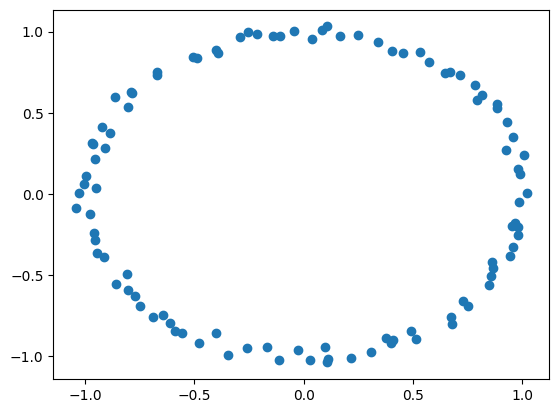

In [ ]:
plt.scatter(samples[6][:, 0], samples[6][:, 1])
plt.show()

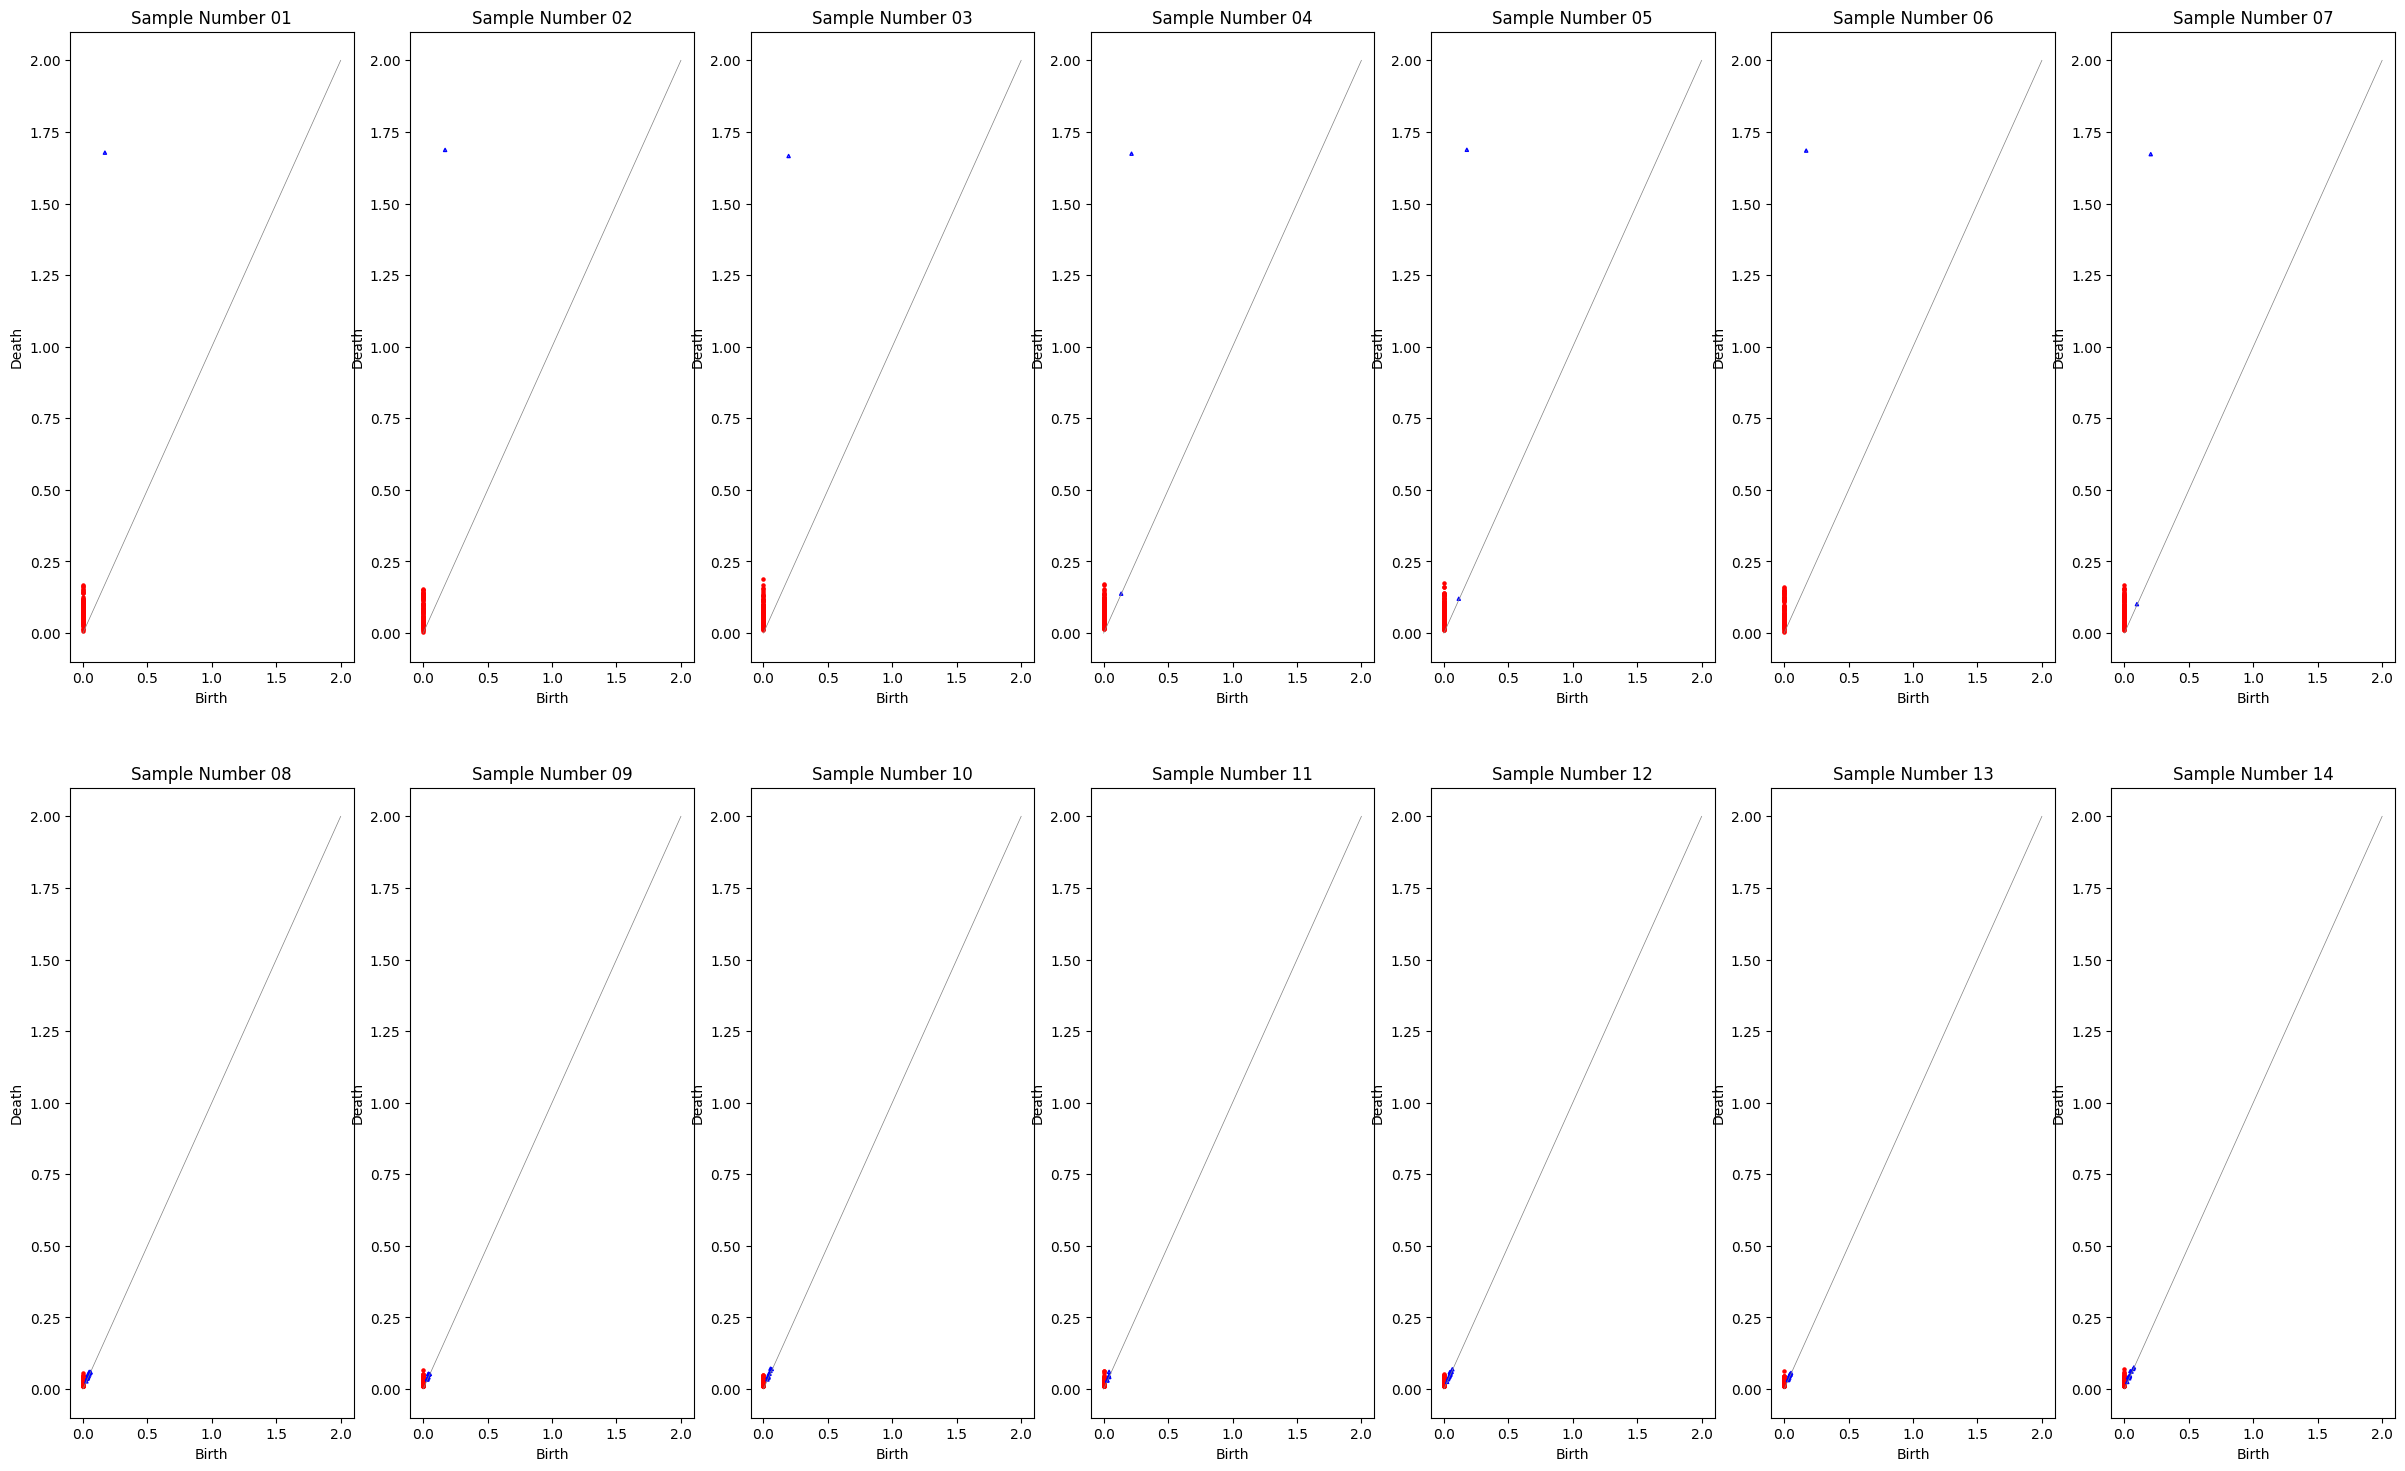

In [ ]:
titles = ['Sample Number %02d' %(i+1) for i in np.arange(n_samples_per_shape*2)]
plot_Dionysus_PDs(pd0_union, pd1_union, titles)